In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import randint

%matplotlib inline

In [2]:
# Load and prepare data
data = pd.read_csv("../../data/cyclohexane.csv", header=0)

X = data.drop("solvent", axis=1)
best_sample = X.iloc[0].to_numpy().reshape(-1, 1)

In [3]:
plt.rcParams['font.size'] = 12
xticks = np.linspace(0, X.shape[1]-1, 6, dtype=int)
xlabels = X.columns[xticks].astype(float).astype(int).values

def build_plot():
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.ylabel("Intensity (a.u)")
    plt.xlabel("Raman Shift (cm$^{-1}$)")
    plt.xlim([-20, 3296])
    plt.xticks(xticks, labels=xlabels)
    plt.grid(False)
    
    return fig

## Example Raw Spectra

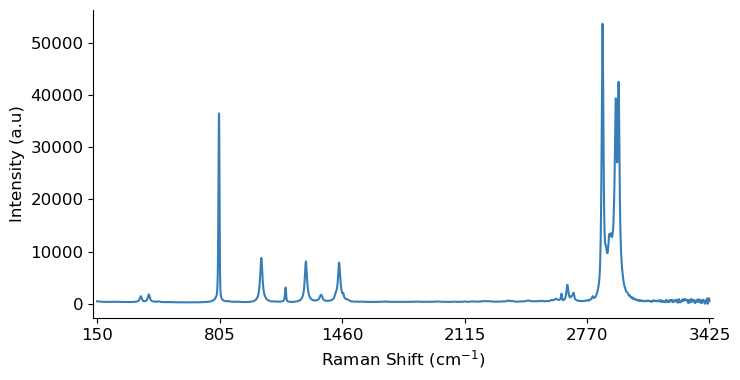

In [4]:
_ = build_plot()
plt.plot(best_sample, "#377eb8");

## Example Batch of Raw Spectra

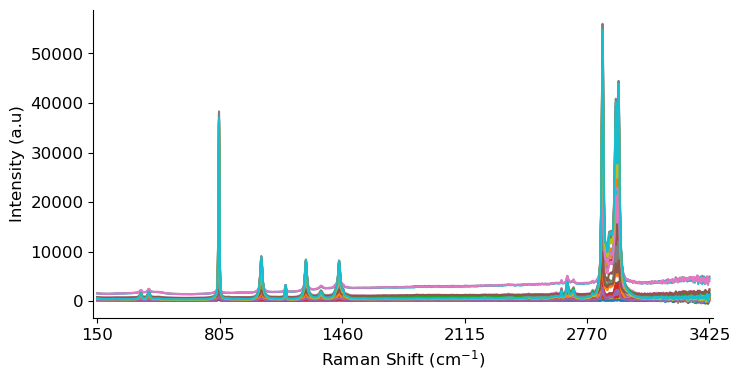

In [5]:
_ = build_plot()
plt.plot(X.iloc[:50, :].T); # semicolon to suppress matplotlib output, can also assign it as _ = plot(.)

In [6]:
def calculate_class_priors(y, print_counts=True):
    """
    Calculates the class prior probabilities for binary classes.

    Args:
        y (array-like):
            Class labels.
        print_counts (bool):
            Print class counts

    Returns:
        dict: 
            Class counts of minority class and majority class.
    """
    # Convert input to NumPy array
    y = np.array(y)
    
    # Get unique classes and their counts
    unique, counts = np.unique(y, return_counts=True)
    
    # Ensure binary classification
    if len(unique) != 2:
        raise ValueError("This function is for binary classes only.")

    class_counts = dict(zip(unique, counts))

    if print_counts:
        print(f"Class counts: {class_counts}")

    return class_counts

    # or comment out the above and uncomment this
    #return pd.Series(y).value_counts().to_dict()

# First set a seed for reproducibility, try changing this to any random number.
np.random.seed(0)

# Lets simulate class labels and split them
y = randint(2, size=X.shape[0])

# Calculate and print percentage of each class in total samples
class_counts = calculate_class_priors(y)

Class counts: {0: 67, 1: 78}


## Intensifying

In [7]:
def intensify(X, m=0, c=0):
    """
    Returns spectra intensified by user-selected multiplicative factor M with constant offset A.

    Args:
        X (array-like):
            Spectral data matrix.
        m (float):
            Multiplicative amplication factor (1% equals same, 1.7 = 70% intensifying for example).
        c (float):
            Baseline amplification factor (constant offset)

    Returns:
        intensified_spectra (array-like): 
            Spectral data matrix with new synthetic samples.
    """
    # default case for bug-proofing, return unaltered data
    if m == 0 and c==0:
        return X
    
    if m == 1:
        S_new = X.copy()
    elif m != 0 and m != 1:
        S_new = X * m

    if c != 0:
        S_new = S_new + c

    return S_new

In [8]:
X_copy = X.copy()

# Separate classes before blending
class_0_samples = X_copy[y == 0]
class_1_samples = X_copy[y == 1]

(67, 3276)


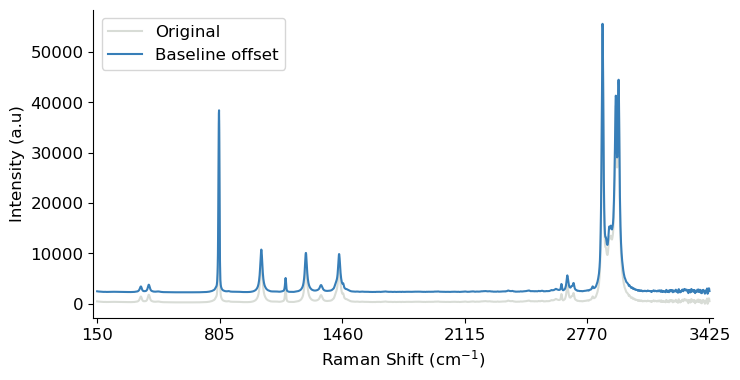

In [9]:
# values per original article
m_values = np.arange(1.01, 1.15, 0.01)
m = 1.0
c = 2000 # extreme example for easy visualation, original article found C=0 to be more appropriate

# Perform intensifying
class_0_intense_spectra = intensify(class_0_samples, m=m, c=c)
print(class_0_intense_spectra.shape)

_ = build_plot()
plt.plot(class_0_samples.iloc[0], "#d8dcd6", label="Original");
plt.plot(class_0_intense_spectra.iloc[0],"#377eb8", label="Baseline offset")
plt.legend();

(67, 3276)


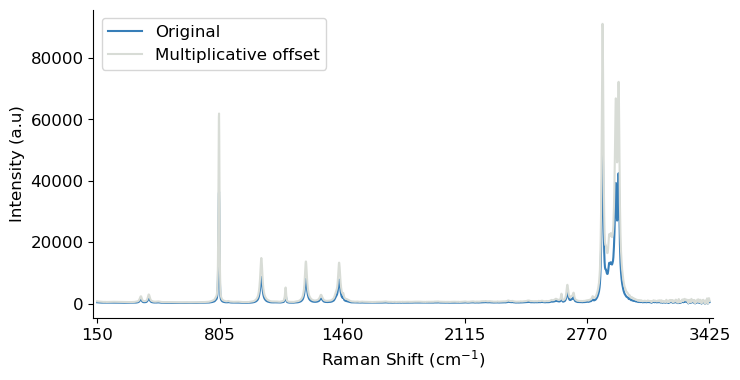

In [10]:
m = 1.7 
c = 0

# Perform intensifying
class_0_intense_spectra = intensify(class_0_samples, m=m, c=c)
print(class_0_intense_spectra.shape)

_ = build_plot()
plt.plot(class_0_samples.iloc[0], "#377eb8", label="Original");
plt.plot(class_0_intense_spectra.iloc[0],"#d8dcd6", label="Multiplicative offset");
plt.legend();

In [11]:
# Lastly you could concat the new data with the original
class_0_augmented_spectra = np.vstack([class_0_samples, class_0_intense_spectra])
class_0_augmented_y = np.full(class_0_augmented_spectra.shape[0], 0)

print(class_0_augmented_spectra.shape)
print(class_0_augmented_y.shape)

(134, 3276)
(134,)


## Blending

In [12]:
def blend(X, weights):
    """
    Returns weighted blending of 2 parent spectra for each intensity point (wavelength)

    Args:
        X (array-like):
            Spectral data matrix.
        weights (array-like):
            Array of weights to apply during blending.

    Returns:
        blended_spectra (array-like): 
            Spectral data matrix with new blended synthetic samples.
    """
    synthetic_samples = []
    num_samples = X.shape[0]

    print("\nStarting blending...")
    start_time = time.time()
    
    # for every two parent spectra calculate N weighted values at each intensity point
    for i in range(num_samples): # parent A
        for j in range(i + 1, num_samples): # parent B

            # 0.1A + 0.9B, 0.2A + 0.8B, 0.3A + 0.7B etc..
            for a, b in zip(weights, reversed(weights)): # for each Wi and (1 - Wi)
                weighted_spectra = (a * X.iloc[i]) + (b * X.iloc[j])  # Sn = (Wi ∗ A) + ((1 - Wi) * b)
                synthetic_samples.append(weighted_spectra) # store new sample
    
    blended_spectra = pd.DataFrame(synthetic_samples, columns=X.columns)
    
    print("Blending took approx: %s minutes" % round((time.time() - start_time) / 60, 4))
    print()

    # returns ((|W| * n) * (n - 1)) / 2 spectra
    return blended_spectra

In [13]:
X_copy = X.copy()

# print priors so we can validate the number of spectra generated
class_counts = calculate_class_priors(y)

# weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weights = np.arange(0.1, 1, 0.1)

# Separate classes before blending
class_0_samples = X_copy[y == 0]
class_1_samples = X_copy[y == 1]

Class counts: {0: 67, 1: 78}


In [14]:
# ((|W| * n) * (n - 1)) / 2 spectra
print(f"Manually calculated number of blended samples for class 0: {((9 * 67) * (67 - 1)) / 2}")
print(f"Auto calculated number of blended samples for class 0: {((len(weights) * class_0_samples.shape[0]) * (class_0_samples.shape[0] - 1)) / 2}")

# Perform blending
class_0_blended_spectra = blend(class_0_samples, weights)
print(f"Number of blended spectra returned {class_0_blended_spectra.shape[0]}")

# Combine original data with blended data
class_0_augmented = np.vstack([class_0_samples, class_0_blended_spectra])
class_0_y_labels = np.full(class_0_augmented.shape[0], 0)

print(f"Number of augmented class 0 spectra {class_0_augmented.shape[0]}")

Manually calculated number of blended samples for class 0: 19899.0
Auto calculated number of blended samples for class 0: 19899.0

Starting blending...
Blending took approx: 0.0606 minutes

Number of blended spectra returned 19899
Number of augmented class 0 spectra 19966


In [15]:
# ((|W| * n) * (n - 1)) / 2 spectra
print(f"Manually calculated number of blended samples for class 1: {((9 * 78) * (78 - 1)) / 2}")
print(f"Auto calculated number of blended samples for class 1: {((len(weights) * class_1_samples.shape[0]) * (class_1_samples.shape[0] - 1)) / 2}")

# Perform blending
class_1_blended_spectra = blend(class_1_samples, weights)
print(f"Number of blended spectra returned {class_1_blended_spectra.shape[0]}")

# Combine original data with blended data
class_1_augmented = np.vstack([class_1_samples, class_1_blended_spectra])
class_1_y_labels = np.full(class_1_augmented.shape[0], 1)

print(f"Number of augmented class 1 spectra {class_1_augmented.shape[0]}")

Manually calculated number of blended samples for class 1: 27027.0
Auto calculated number of blended samples for class 1: 27027.0

Starting blending...
Blending took approx: 0.129 minutes

Number of blended spectra returned 27027
Number of augmented class 1 spectra 27105


In [16]:
# Let's see how the priors change
print("Original Class 0 prior:", np.round(class_0_samples.shape[0] / X_copy.shape[0], 3))
print("Original Class 1 prior:", np.round(class_1_samples.shape[0] / X_copy.shape[0], 3))

new_total_data = class_0_augmented.shape[0] + class_1_augmented.shape[0]
print("New Class 0 prior:", np.round(class_0_augmented.shape[0]/new_total_data, 3))
print("New Class 1 prior:", np.round(class_1_augmented.shape[0]/new_total_data, 3))

Original Class 0 prior: 0.462
Original Class 1 prior: 0.538
New Class 0 prior: 0.424
New Class 1 prior: 0.576


# Toy example to show increase in priors when blending

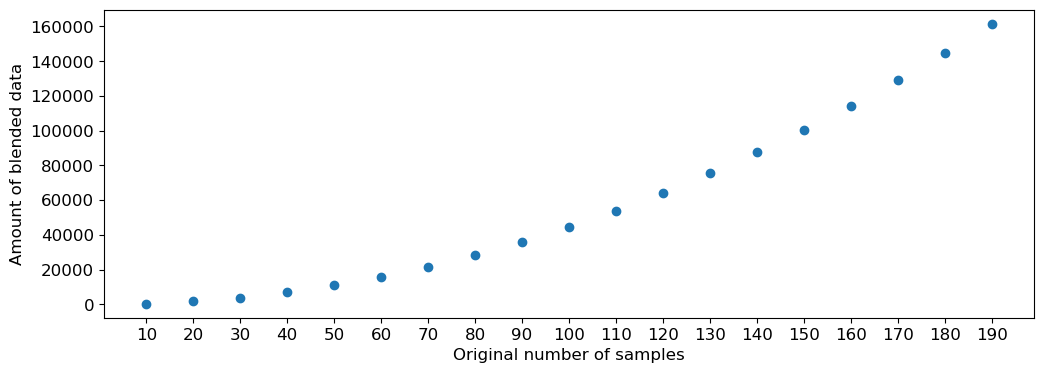

In [18]:
# simulate increasing number of samples
sim_sample_batches= np.arange(10, 200, 10)
num_weights = 9

synth_data_created = []
for num_samples in sim_sample_batches:
    synth_data_created.append(((num_weights * num_samples) * (num_samples - 1)) / 2)

plt.figure(figsize=(12, 4))
plt.grid(False)
plt.xticks(sim_sample_batches)
plt.ylabel("Amount of blended data")
plt.xlabel("Original number of samples")
plt.scatter(sim_sample_batches, synth_data_created);